https://github.com/microsoft/onnxruntime-inference-examples/tree/main/c_cxx

In [37]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [38]:
ort.__version__

'1.15.1'

# onnxruntime本身支持动态batch

In [39]:
# support dynamic batch
dynamic_batch = True

In [40]:
image_path = r"../cat.jpg"
classes_path = r"../imagenet_class_index.txt"
model_path = r"../models/shufflenet_v2_x0_5_dynamic_batch.onnx" if dynamic_batch else r"../models/shufflenet_v2_x0_5.onnx"
mode = "cuda"

# load image and preprocess

In [41]:
image = cv2.imread(image_path)

## BGR2RGB

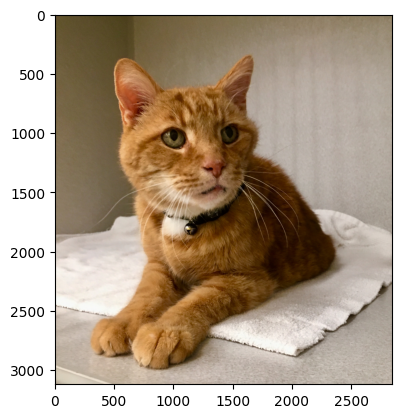

In [42]:
image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
plt.imshow(image)

## resize

In [43]:
print(image.shape)
image = cv2.resize(image, (224, 224))
print(image.shape)

(3119, 2841, 3)
(224, 224, 3)


## 归一化

In [44]:
print(image.min(), image.max())
image = image.astype(np.float32)
image /= 255.0
print(image.min(), image.max())

0 255
0.0 1.0


## 标准化 减去均值,除以标准差

In [45]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [46]:
print(image.min(), image.max())
image -= mean
image /= std
print(image.min(), image.max())

0.0 1.0
-2.0836544 2.5354247


## HWC -> NCHW

In [47]:
image.shape, image.dtype

((224, 224, 3), dtype('float32'))

In [48]:
x = np.expand_dims(image.transpose([2, 0, 1]), axis=0)
x.shape

(1, 3, 224, 224)

In [49]:
# 测试动态batch,生成2张图片
if dynamic_batch:
    x = x.repeat(2, axis=0)
    print(x.shape)

(2, 3, 224, 224)


# onnxruntime

## load onnx model

In [50]:
ort.get_available_providers()

['CPUExecutionProvider']

In [51]:
so = ort.SessionOptions()
so.log_severity_level = 3
providers = {
    "cpu":  ["CPUExecutionProvider"],
    # https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html
    "cuda": [
            ("CUDAExecutionProvider", {
                "device_id": 0,
                "arena_extend_strategy": "kNextPowerOfTwo",
                "gpu_mem_limit": 8 * 1024 * 1024 * 1024, # 8GB
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "do_copy_in_default_stream": True,
            }),
            "CPUExecutionProvider",
        ],
    # tensorrt
    # https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html
    # it is recommended you also register CUDAExecutionProvider to allow Onnx Runtime to assign nodes to CUDA execution provider that TensorRT does not support.
    # set providers to ["TensorrtExecutionProvider", "CUDAExecutionProvider"] with TensorrtExecutionProvider having the higher priority.
    "tensorrt": [
            ("TensorrtExecutionProvider", {
                "device_id": 0,
                "trt_max_workspace_size": 8 * 1024 * 1024 * 1024, # 8GB
                "trt_fp16_enable": False,
                # "trt_timing_cache_enable": True, # Enabling trt_timing_cache_enable will enable ORT TRT to use TensorRT timing cache to accelerate engine build time on a device with the same compute capability.
            }),
            ("CUDAExecutionProvider", {
                "device_id": 0,
                "arena_extend_strategy": "kNextPowerOfTwo",
                "gpu_mem_limit": 8 * 1024 * 1024 * 1024, # 8GB
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "do_copy_in_default_stream": True,
            }),
            "CPUExecutionProvider",
        ]
}[mode]

In [52]:
session = ort.InferenceSession(model_path, sess_options=so, providers=providers)

d:\miniconda3\envs\pytorch\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [53]:
inputs  = session.get_inputs()
outputs = session.get_outputs()
print(inputs)
print(outputs)

In [54]:
print(f"inputs  name: {inputs[0].name},  type: {inputs[0].type}, shape: {inputs[0].shape}")
print(f"outputs name: {outputs[0].name}, type: {outputs[0].type}, shape: {outputs[0].shape}")

inputs  name: images,  type: tensor(float), shape: ['batch_size', 3, 224, 224]
outputs name: classes, type: tensor(float), shape: ['batch_size', 1000]


## inference

In [55]:
result = session.run(None, {inputs[0].name: x})
len(result)

1

In [56]:
result[0].shape

(2, 1000)

In [57]:
scores: np.ndarray = result[0]
scores.shape, scores.min(), scores.max(), scores.sum()

((2, 1000), -9.089846, 8.632017, -968.1489)

# postprocess

### softmax

In [58]:
def softmax(array: np.ndarray, axis=-1) -> np.ndarray:
    array -= array.max(axis=axis, keepdims=True)
    return np.exp(array) / np.exp(array).sum(axis=-1, keepdims=True)

In [59]:
scores_ = softmax(scores)
scores_.min(), scores_.max(), scores_.sum()

(7.539342e-09, 0.3748354, 1.9999999)

In [60]:
scores_.shape

(2, 1000)

### topk

In [61]:
def topk(array: np.ndarray, topk=1):
    indexes = array.argsort(axis=-1)[:, -topk:]   # 升序的id
    scores = np.zeros((array.shape[0], topk))
    for i, (score, index) in enumerate(zip(scores_, indexes)):
        scores[i] = score[index]
    return indexes[:, ::-1], scores[:, ::-1]       # 升序2降序

In [62]:
index, score = topk(scores_, topk=5)
print(index)
print(score)

[[285 282 186 281 184]
 [285 282 186 281 184]]
[[0.3748354  0.15150513 0.07632795 0.0586235  0.03031835]
 [0.3748354  0.15150513 0.07632795 0.0586235  0.03031835]]


# classes name

In [63]:
with open(classes_path, mode="r", encoding="utf-8") as f:
    classes = f.read().splitlines()
len(classes)

1000

In [64]:
names = np.array(classes)[index]
names

array([['Egyptian_cat', 'tiger_cat', 'Norwich_terrier', 'tabby',
        'Irish_terrier'],
       ['Egyptian_cat', 'tiger_cat', 'Norwich_terrier', 'tabby',
        'Irish_terrier']], dtype='<U30')

In [65]:
# 只打印第一张图片的结果
for i, sc, name in zip(index[0], score[0], names[0]):
    print(f"{i} => {'{:.4f}'.format(sc)} => {name}")

285 => 0.3748 => Egyptian_cat
282 => 0.1515 => tiger_cat
186 => 0.0763 => Norwich_terrier
281 => 0.0586 => tabby
184 => 0.0303 => Irish_terrier
